# ECE 351 - Lab #6
### Collin Heist
#### Partial Fraction Expansion

## Introduction
The purpose of this lab is to learn the intricacies of the `scipy.signal.residue()` function. We'll be using this function to perform a partial fraction decomposition on our $H(s)$ transfer functions, saving us the hassle of hand-calculating the decomposed transfer function.

## Function Declarations & Setup

In [1]:
# Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import warnings
warnings.filterwarnings("ignore")

# Color list for multiple lines on each subplot
colors = ["red", "blue", "green", "gray"]

# Generic Function to create a plot
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"],
                title=["Plot"], num_rows=1):
    plt.figure(figsize=(18, 14), dpi=300)
    for c, (x_vals, y_vals, x_labels, y_labels, titles) in enumerate(
        zip(x, y, xLabel, yLabel, title)):
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(num_rows, 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            plt.plot(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='lower right')
    
    plt.show()
    
# Defintion of the step function
def u(x_vals, zero_val=0):
    return (np.asarray([0 if x < zero_val else 1 for x in x_vals]))

## Part 1

In [2]:
# y(t) response to u(t) * h(t)
def step_response(t):
    return (0.5 * u(t) * (1 + 2 * np.exp(-6 * t) - np.exp(-4 * t)))

# H(s)
def transfer_function():
    return ([1, 6, 12], [1, 10, 24])

# H(s) step response
def transfer_step_function():
    return ([1, 6, 12], [1, 10, 24, 0])

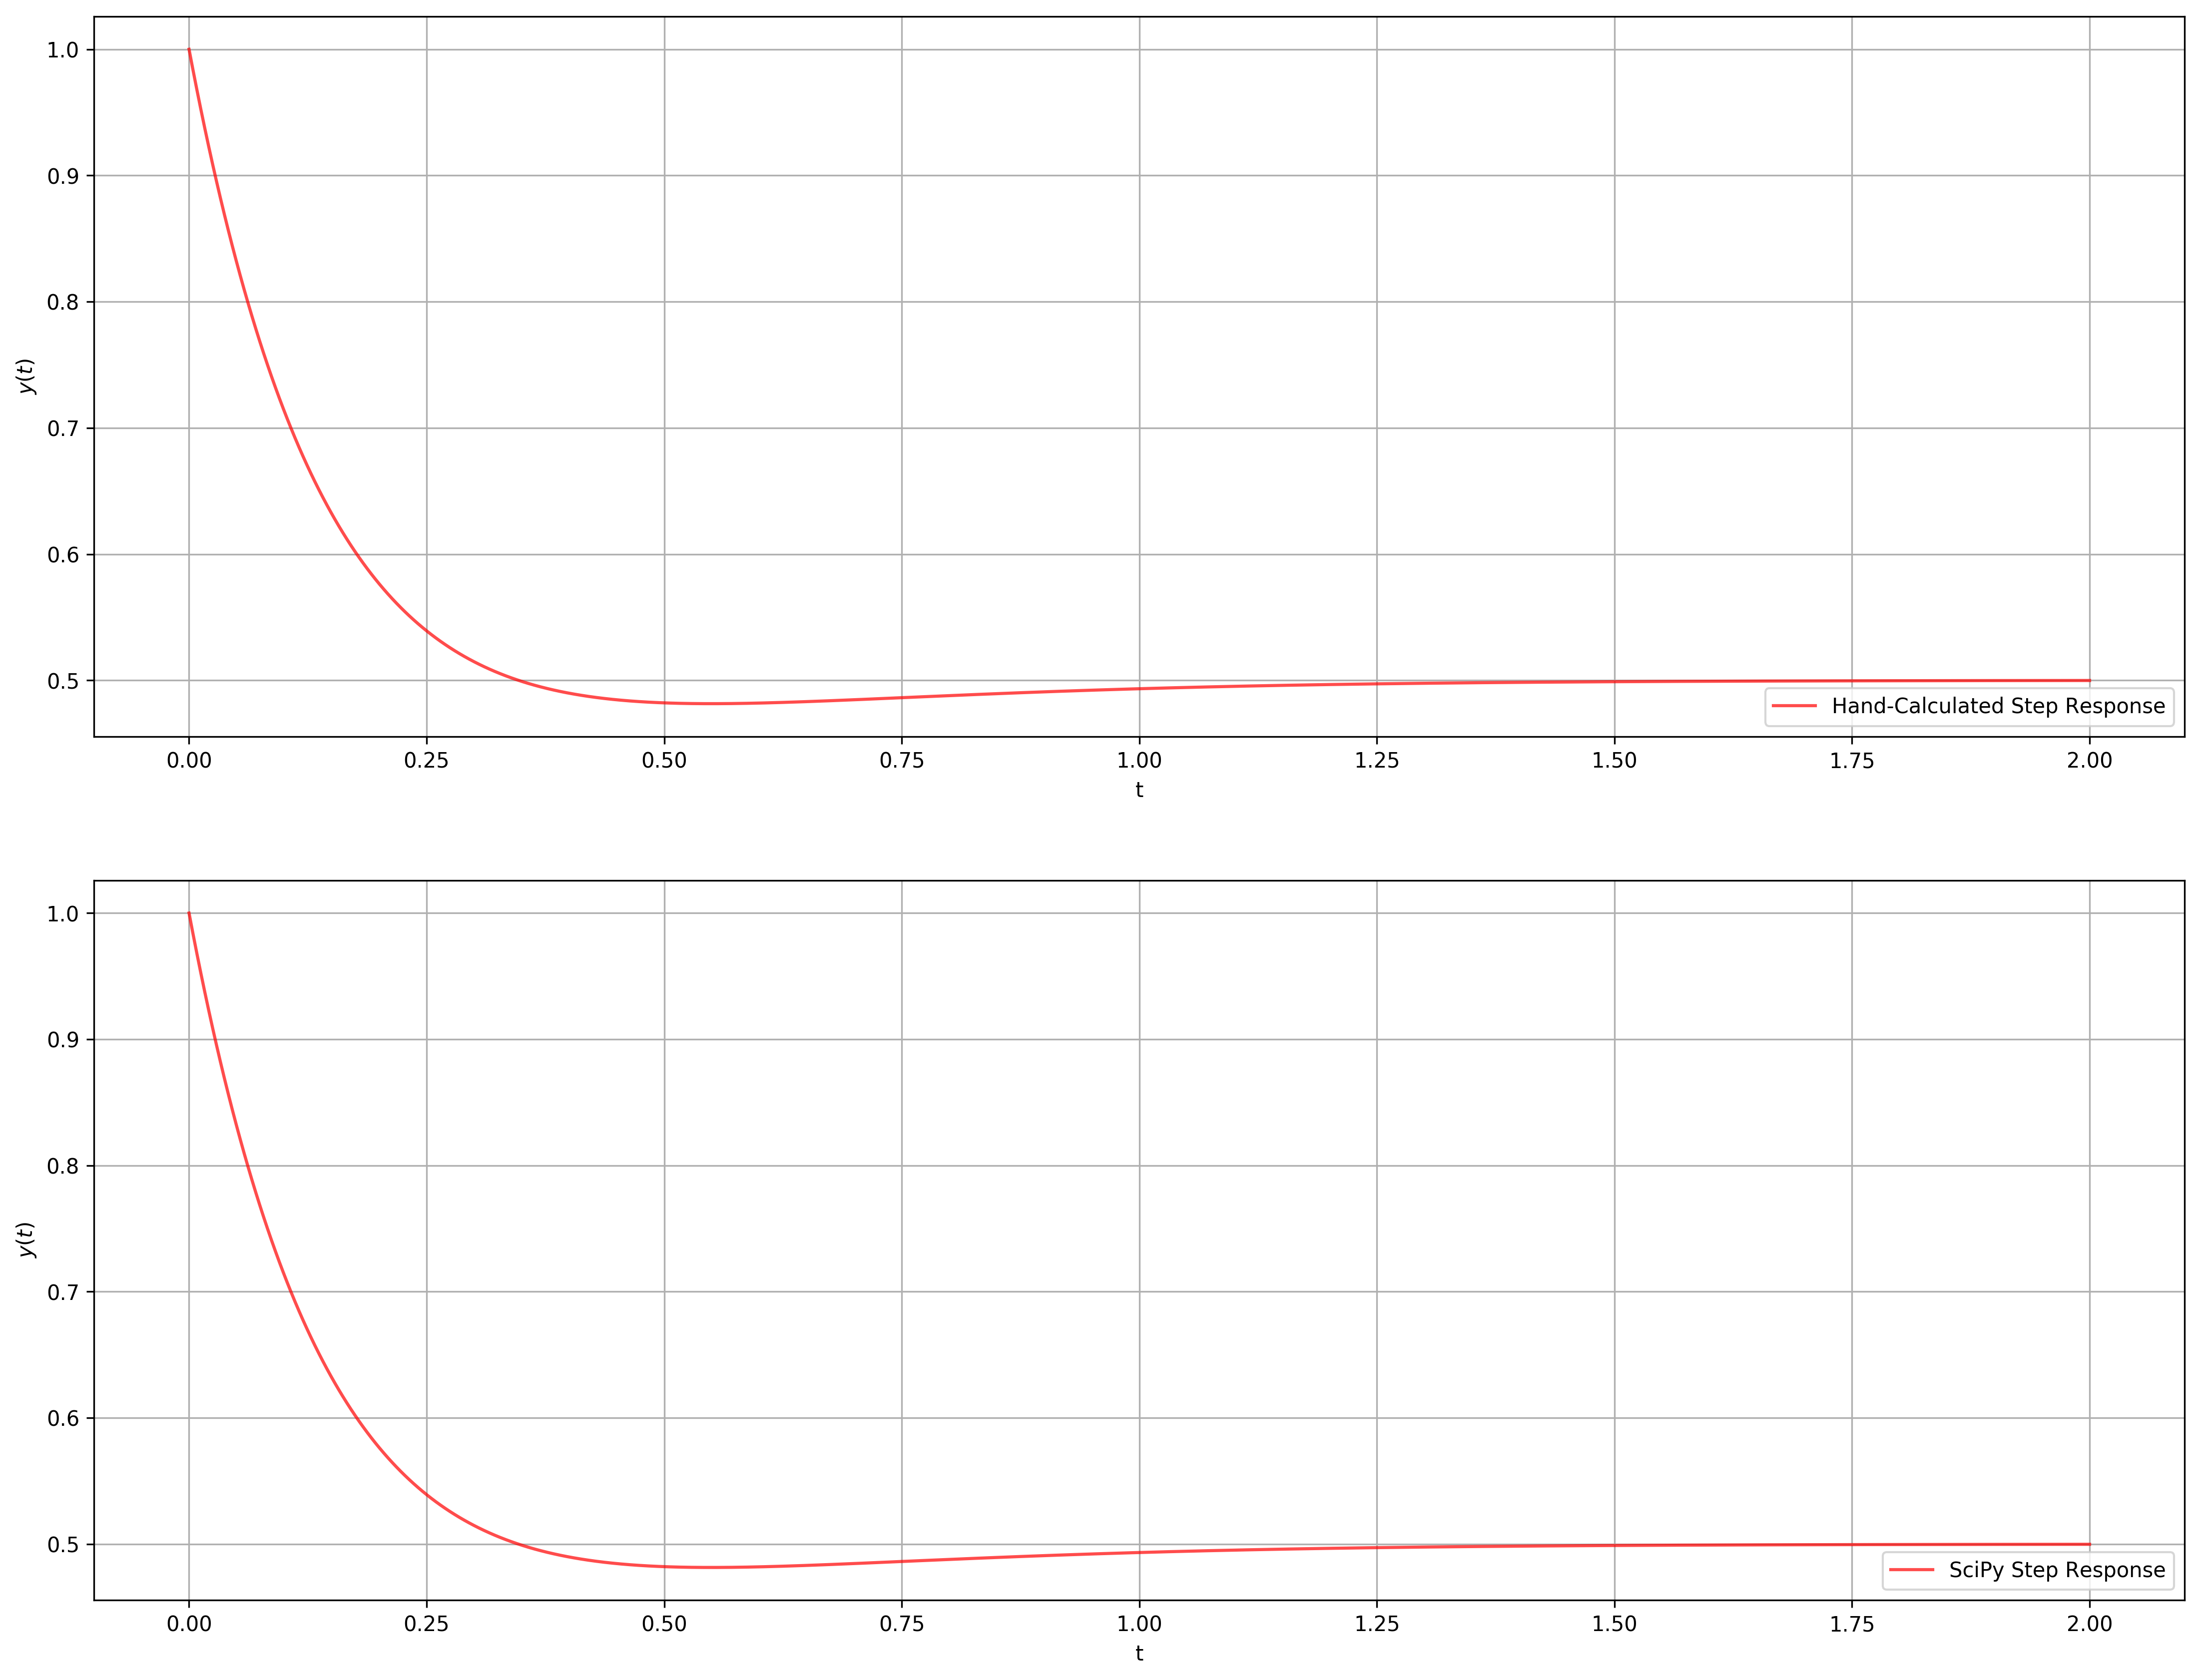

In [3]:
step_size = 1e-5
t = np.arange(0, 2 + step_size, step_size)
step_t, step_y = scipy.signal.step(transfer_function(), T=t)
create_plot([t, step_t], [(step_response(t), ), (step_y, )],
            ["t", "t"], ["$y(t)$", "$y(t)$"],
            [("Hand-Calculated Step Response", ), ("SciPy Step Response", )], 2)

In [4]:
print ("Response Function, decomposed:")
r, p, k = scipy.signal.residue(transfer_step_function()[0], transfer_step_function()[1])
for (const, root) in zip(r, p):
    print ("%0.1f/(s%+0.1f)+" % (const, abs(root)) if root < 0 else "%0.1f/(s-%0.1f)+" % (const, root), end="")
print (k[0])

Response Function, decomposed:
1.0/(s+6.0)+-0.5/(s+4.0)+0.5/(s-0.0)+0.0


The results of `scipy.signal.residue()` is $\frac{1}{s+6}-\frac{0.5}{s+4}+\frac{0.5}{s}$, which is exactly equal to my hand-derived Y(s), $\frac{1}{2s}+\frac{1}{s+6}-\frac{1}{2(s+4)}$. Meaning the partial fraction decomposition is correct, but simply in a different order.

## Part 2
The equation describing the system, once a laplace transform is applied, results in the following:
$$Y(s)(s^5+18s^4+218s^3+2036s^2+9085s+25250)=25250X(s)$$
Resulting in the transfer function (with $\frac{1}{s}$ multiplied in to account for the step response):
$$H(s)=\frac{25250}{s^5+18s^4+218s^3+2036s^2+9085s+25250}\cdot \frac{1}{s}$$
We'll need the $\frac{1}{s}$ for this equation (the one going into our `.residue()` function) because all the function does is perform the partial fraction decomposition of the provided fraction. This is different from the `.step()` function I'll be using later, as that function automatically applies the $\frac{1}{s}$ multiplication for us. 

In [5]:
# Response, times 1/s to account for step input
def partial_step_response():
    return ([25250], [1, 18, 218, 2036, 9085, 25250, 0])

def cosine_method(t, constants, roots):
    y = 0
    for (c, r) in zip(constants, roots):
        y += (abs(c) * np.exp(r.real * t) * np.cos(r.imag * t + np.angle(c)) * u(t))
    
    return y

R:
  [[ 1.        +0.j        ]
 [-0.48557692+0.72836538j]
 [-0.48557692-0.72836538j]
 [-0.21461963+0.j        ]
 [ 0.09288674-0.04765193j]
 [ 0.09288674+0.04765193j]] 
P:
 [[  0. +0.j]
 [ -3. +4.j]
 [ -3. -4.j]
 [-10. +0.j]
 [ -1.+10.j]
 [ -1.-10.j]] 
K: [0.]


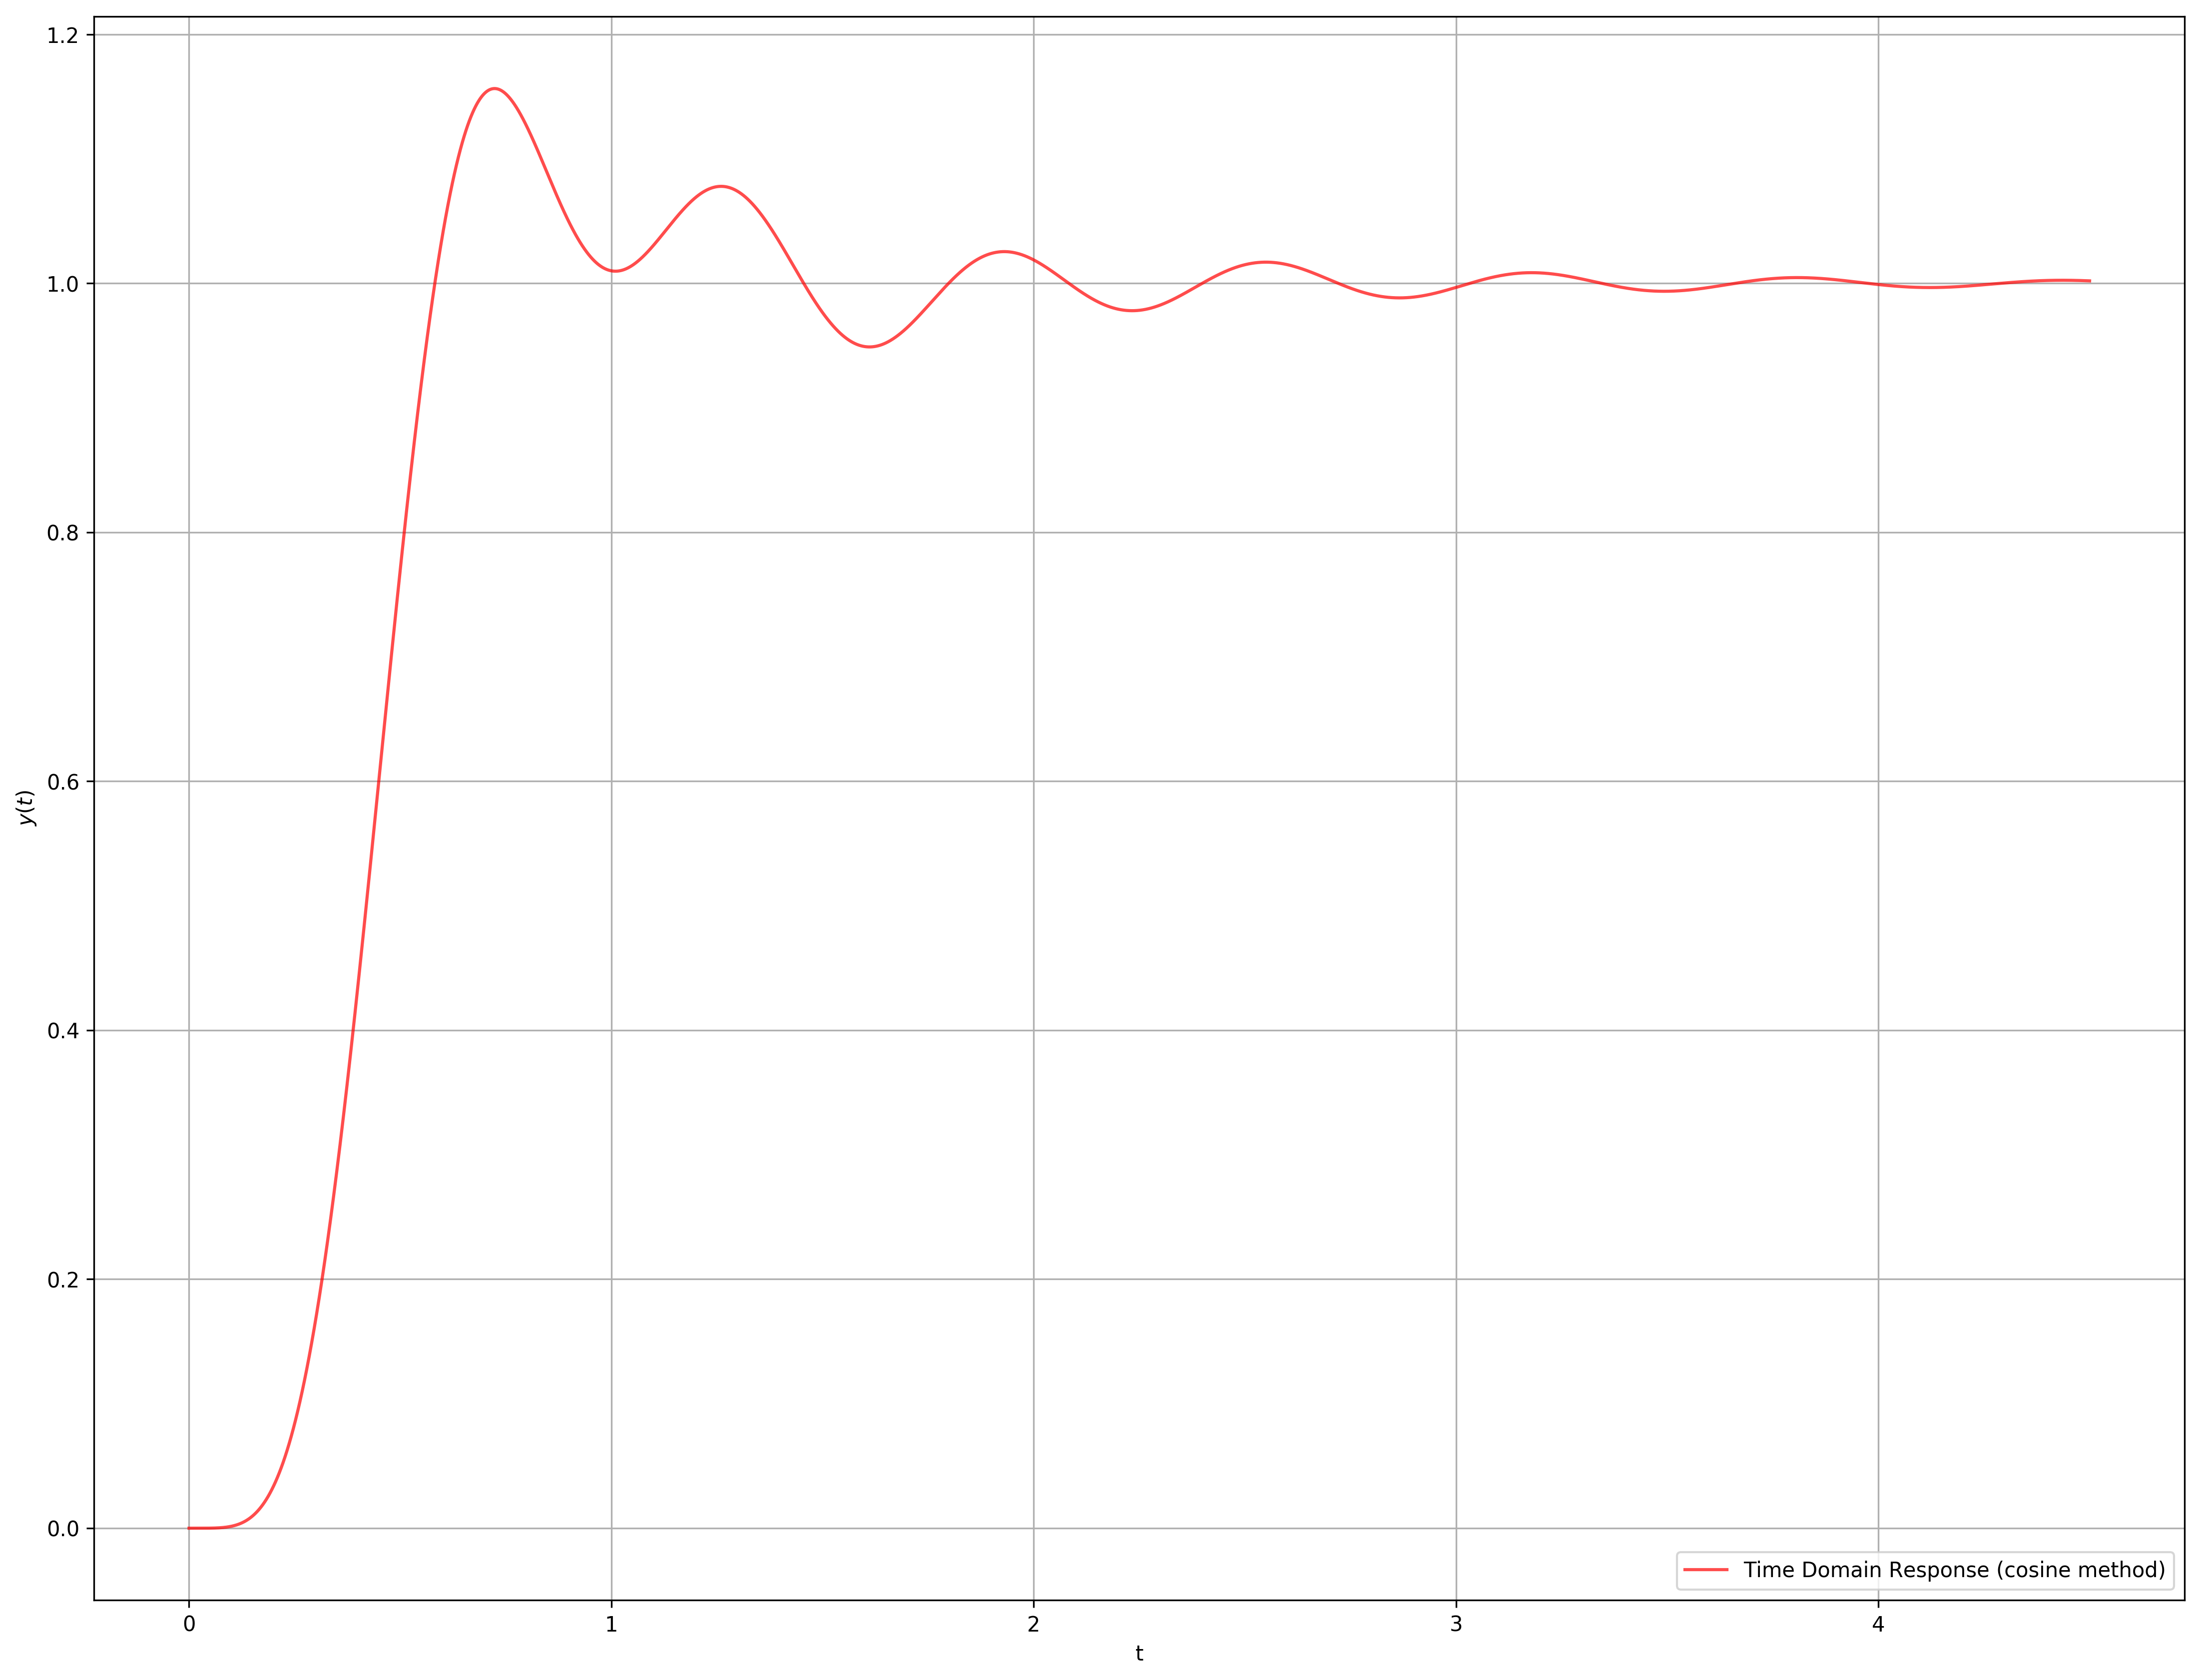

In [6]:
# Compute Partial Fraction Decomposition
r, p, k = scipy.signal.residue(partial_step_response()[0], partial_step_response()[1])
print ("R:\n ", np.c_[r], "\nP:\n", np.c_[p], "\nK:", k)

t = np.arange(0, 4.5 + step_size, step_size)
resp = cosine_method(t, r, p) # Perform the inverse laplace 
create_plot([t], [(resp, )], ["t"], ["$y(t)$"],
            [("Time Domain Response (cosine method)", )], 1)

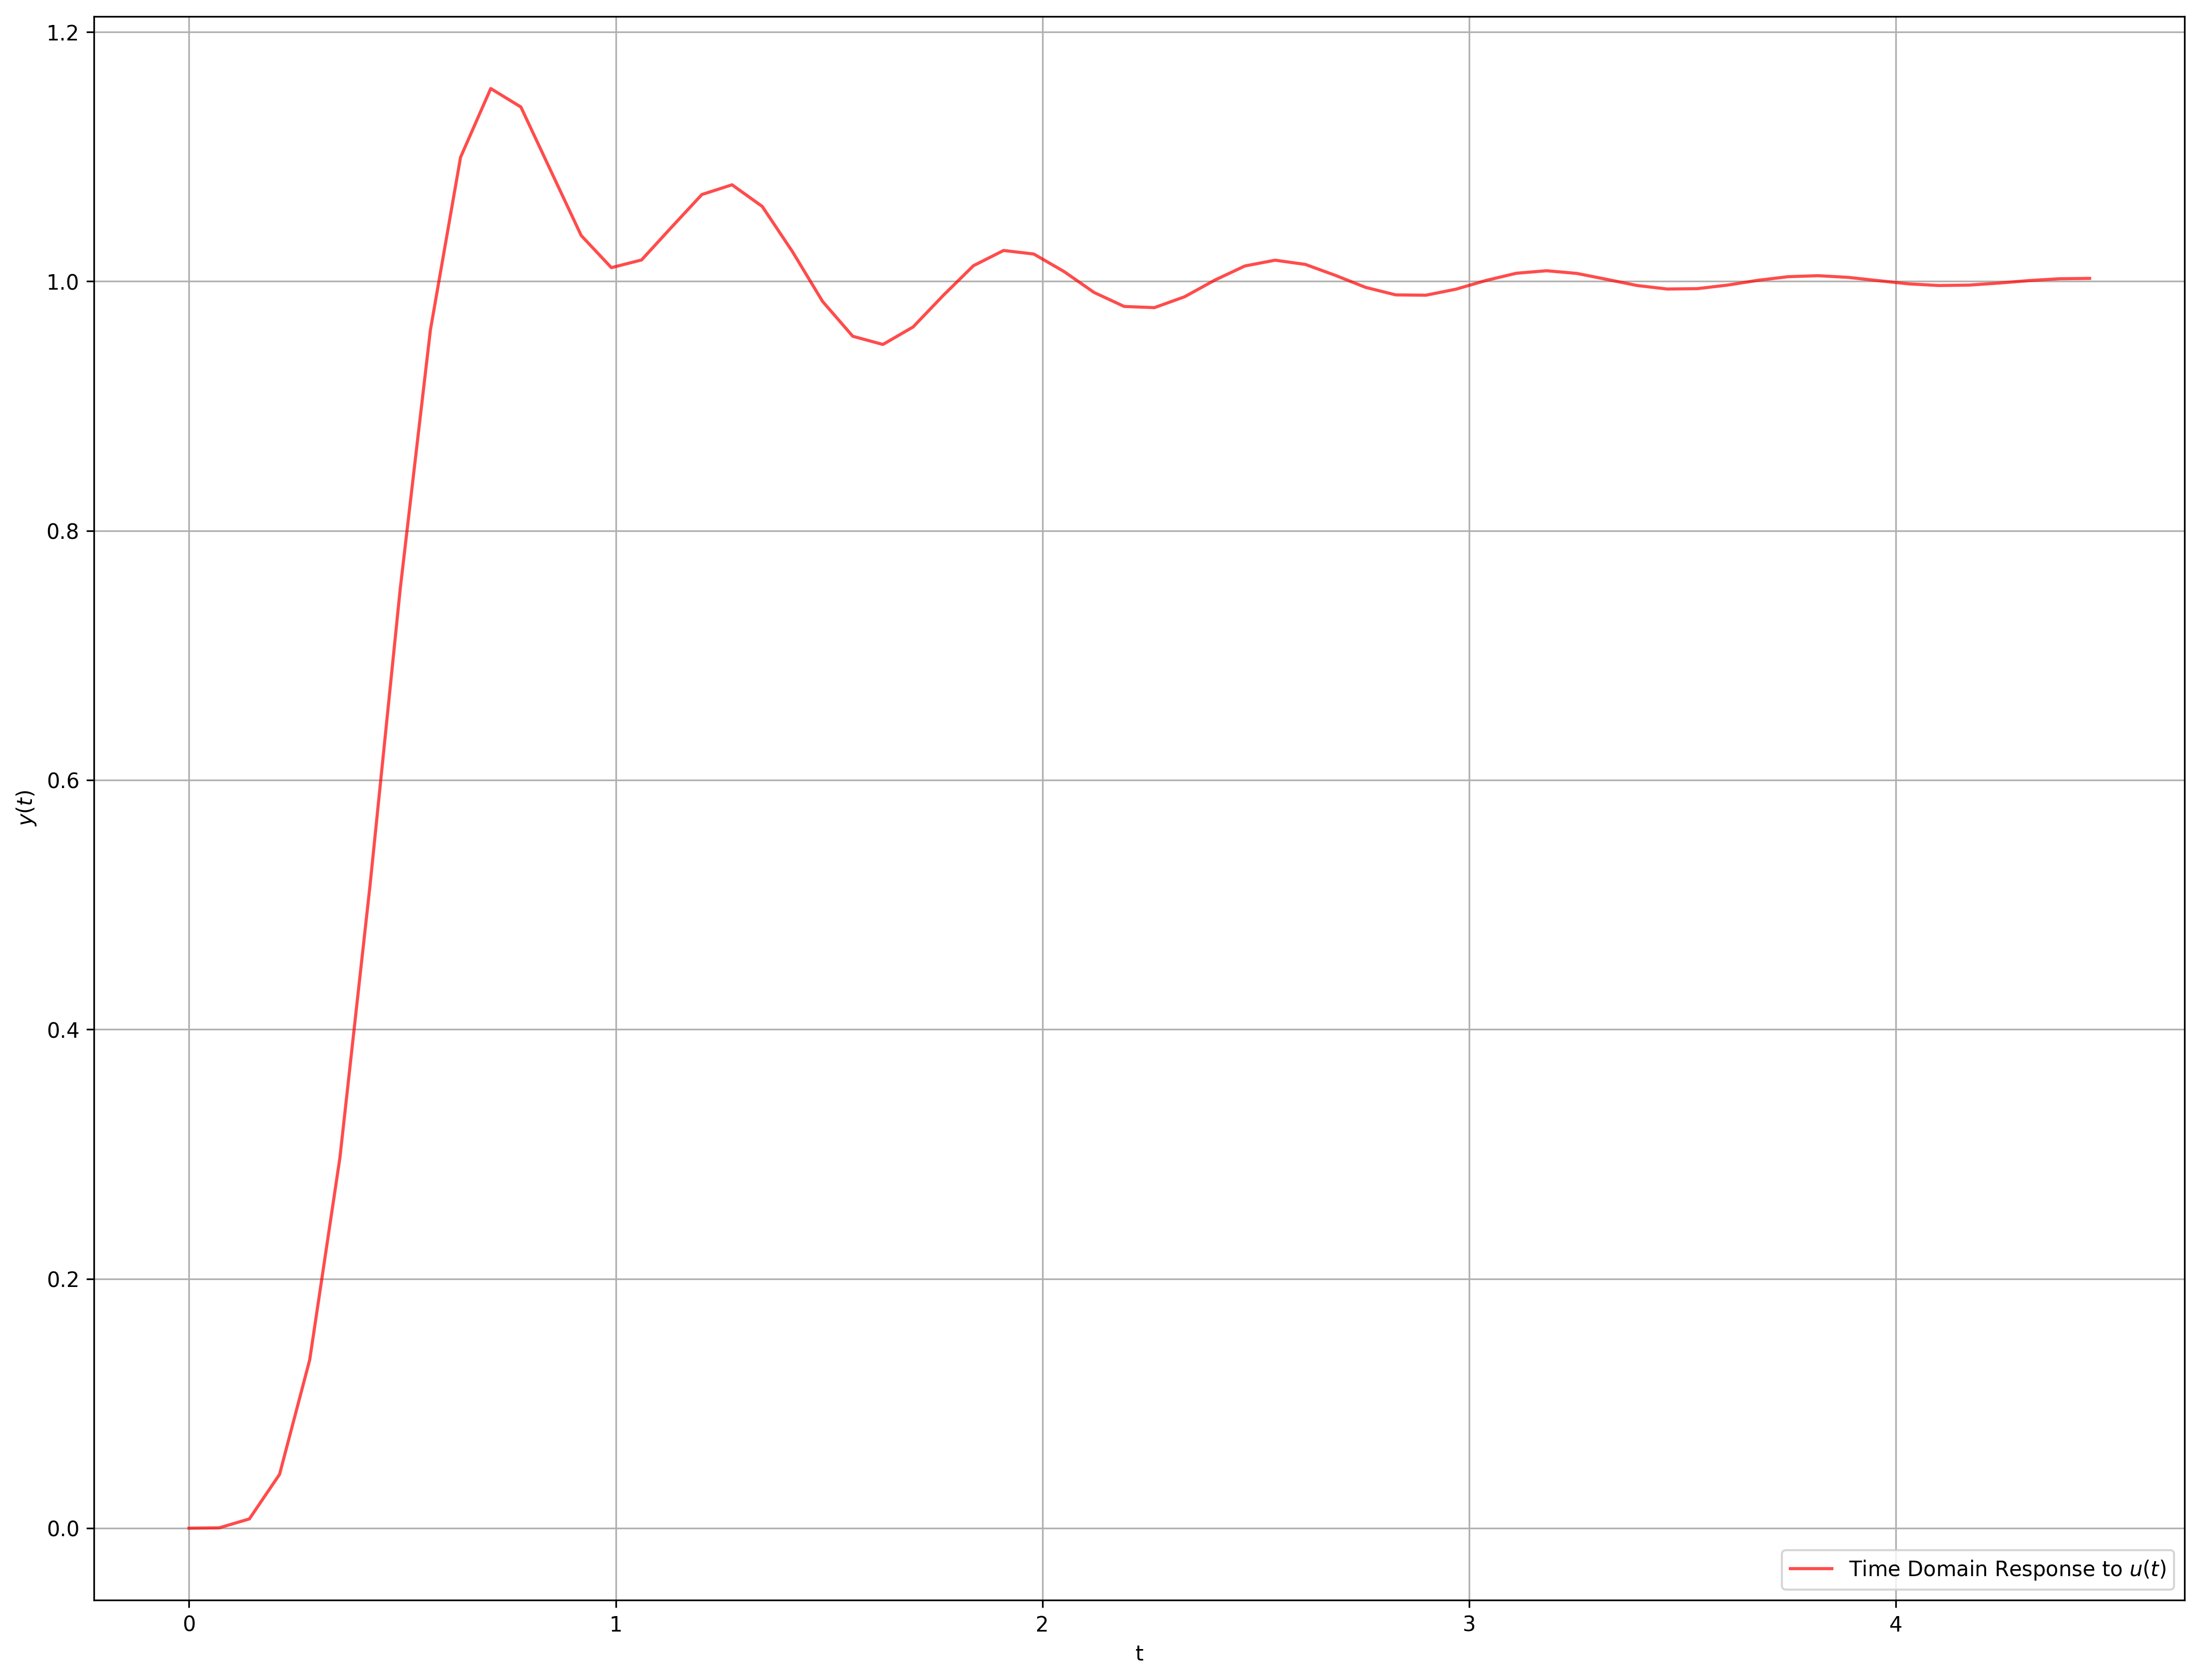

In [7]:
# Generic Transfer function, H(s)
def transfer_function():
    return ([25250], [1, 18, 218, 2036, 9085, 25250])

# Use the scipy.signal.step function to perform the response to u(t)
# Only look at the first 64 values because the .step function expands the range
step_resp_t, step_resp_y = scipy.signal.step(transfer_function())
create_plot([step_resp_t[:64]], [(step_resp_y[:64], )], ["t"], ["$y(t)$"],
            [("Time Domain Response to $u(t)$", )], 1)

### Conclusion
As shown in the two graphs above, using the `signal.step()` function returns a response identical to the calculation using the cosine method. The reason our cosine method works for _real_ roots (not just complex), is because in the event the imaginary portion of the number is simply _zero_, then the sinusoidal part simply goes to zero, resulting in an entirely exponential function. Logically, this makes sense because the response to a non-alternating input is simply an inverse exponential function, starting at the time of the impulse.

### Questions
The only confusion I experience during this lab was due to not yet learning the cosine method of taking a decomposed fraction and converting it to the corresponding inverse laplace function. Once explained, and the errors from the book were corrected, the lab was very interesting and simple to understand.